# Sliding window regression

## Data loading

In [46]:
import pandas as pd

def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/{}/stations/{}.csv'.format(city, station))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    df.set_index('moment', drop=False, inplace=True)
    return df


def get_weather_updates(city):
    df = pd.read_csv('challenge_data/{}/weather.csv'.format(city))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    df.set_index('moment', drop=False, inplace=True)
    return df

## Pre-processing

In [49]:
def add_temporal_features(df):
    df['weekday'] = df['moment'].map(lambda m: str(m.weekday()))
    df['hour'] = df['moment'].map(lambda m: str(m.hour))
    df['minute'] = df['moment'].map(lambda m: m.minute)
    return df

    
def add_weather_updates(df, weather_df):
    w_times = pd.Series(weather_df['moment'].values, weather_df['moment'])
    w_times.sort_values(inplace=True)
    df['moment_weather'] = w_times.reindex(df['moment'], method='nearest').values
    joined_df = pd.merge(
        left=df,
        right=weather_df,
        left_on='moment_weather',
        right_on='moment',
        suffixes=('', '_y')
    )
    joined_df.drop('moment_y', 1, inplace=True)
    return joined_df


def preprocess(df, city):
    df = df.resample('10min', label='right', closed='right').ffill()
    df['moment'] = df.index
    
    df['prev_bikes'] = df['bikes'].shift(1)
    df.dropna(inplace=True) # The first row doesn't not have any prev_bikes
    
    df = add_temporal_features(df)
    df = add_weather_updates(df, get_weather_updates(city))
    df.set_index('moment', drop=False, inplace=True)
    
    return df

## Temporal train-test split

In [3]:
def split_train_test(X, y, t0, t1, t2):
    X_train = X[(X.index >= t0) & (X.index < t1)].copy()
    X_test = X[(X.index >= t1) & (X.index <= t2)].copy()
    y_train = y[(X.index >= t0) & (X.index < t1)].copy()
    y_test = y[(X.index >= t1) & (X.index <= t2)].copy()
    return X_train, X_test, y_train, y_test

## Fit and predict a single station

In [227]:
features = [
    'weekday',
    'hour',
    'minute',
    'clouds',
    'humidity',
    'pressure',
    'temperature',
    'wind',
    'prev_bikes'
]

city = 'paris'
station = '01020-rivoli-concorde'

df = preprocess(get_station_updates(city, station), city)
X = df[features]
y = df['bikes']

t2 = X.index.max()
t1 = t2 - pd.Timedelta('5 days')
t0 = t1 - pd.Timedelta('12 days')

X_train, X_test, y_train, y_test = split_train_test(X, y, t0, t1, t2)

In [234]:
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing

model = ensemble.RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_leaf=2
).fit(X_train, y_train)

### "Based on the truth" method scoring

In [235]:
y_pred = pd.Series(model.predict(X_test), index=y_test.index)

metrics.mean_absolute_error(y_test, y_pred)

2.4041137914562865

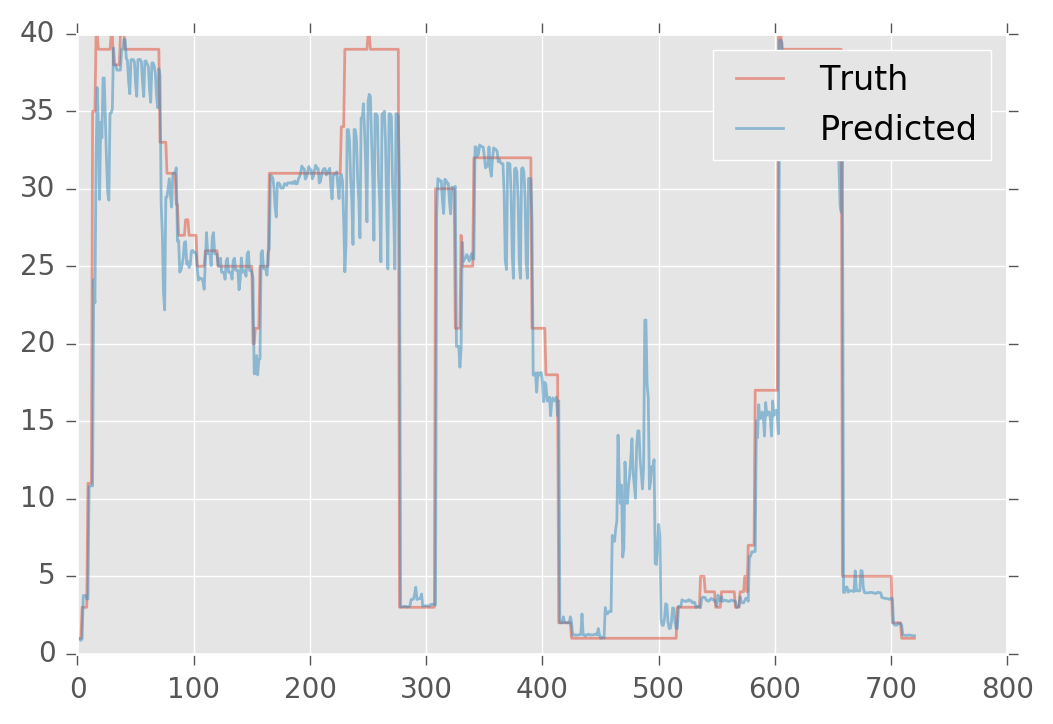

In [236]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.plot(y_test[-1000:].values, alpha=0.5, label='Truth')
ax.plot(y_pred[-1000:].values, alpha=0.5, label='Predicted')
ax.legend()

### "Sliding window" method scoring

In [237]:
y_pred_window = [0] * len(X_test)
y_pred_window[0] = model.predict([X_test.ix[0]])[0]

for i in range(1, len(X_test)):
    x = X_test.ix[i].copy()
    x['prev_bikes'] = y_pred[i-1]
    y_pred_window[i] = model.predict([x])[0]

In [238]:
metrics.mean_absolute_error(y_test, y_pred_window)

3.3629767885583441

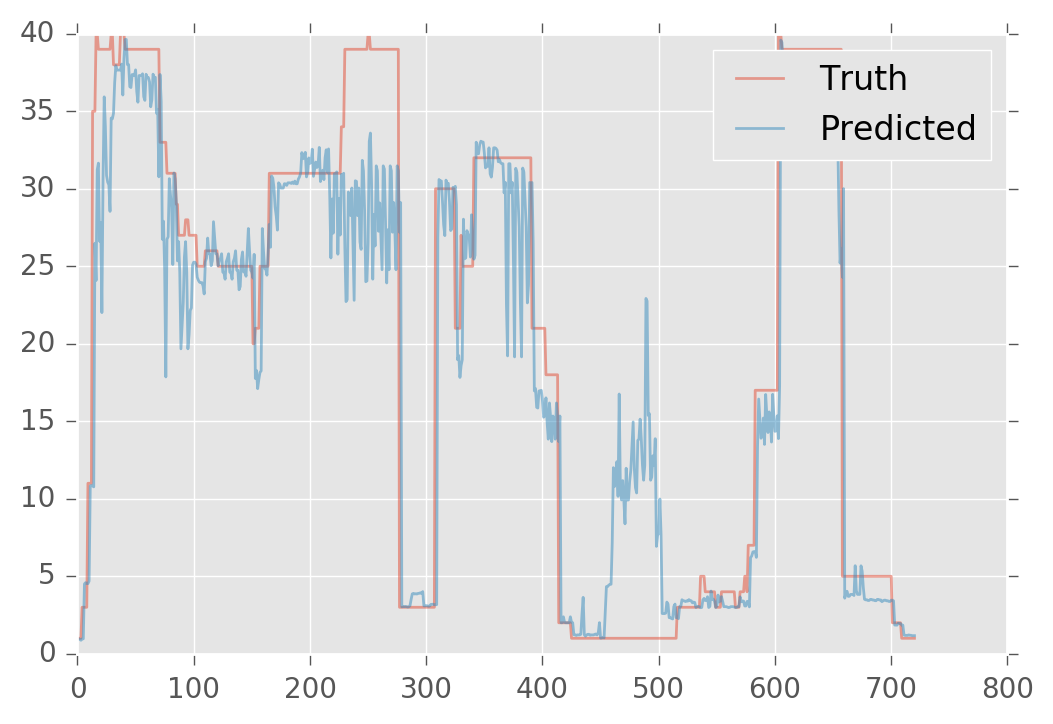

In [239]:
fig, ax = plt.subplots()
ax.plot(y_test.values, alpha=0.5, label='Truth')
ax.plot(y_pred_window, alpha=0.5, label='Predicted')
ax.legend()

## Build a model for each station through grid-search

In [216]:
from sklearn import metrics
from sklearn import model_selection


model = ensemble.RandomForestRegressor()

grid_search = model_selection.GridSearchCV(
    estimator=model,
    param_grid={
        'n_estimators': (5, 8, 12, 50),
        'max_depth': (1, 3, 4, 10),
        'min_samples_leaf': (1, 2, 3, 4)
    },
    scoring=metrics.make_scorer(metrics.mean_absolute_error)
)

model = ensemble.RandomForestRegressor(
    n_estimators=5,
    max_depth=10,
    min_samples_leaf=2
)

to_predict_df = pd.read_csv('challenge_data/test-blank.csv', index_col=0)

since = df['moment'].min()
until = df['moment'].max()

regressors = {}
last_bikes = {}

for station, group in to_predict_df.groupby('station'):
    city = group['city'][0]
    df = preprocess(get_station_updates(city, station), city)
    df = df[df.index > until - pd.Timedelta(days=21)]
    X = df[features]
    y = df['bikes']
    grid_search.fit(X, y)
    regressors[station] = grid_search.best_estimator_
    last_bikes[station] = y[-1]

## Forecast the number of bikes in test set

### Create a list of timesteps for which to run simulations

In [162]:
import datetime as dt

step = dt.timedelta(minutes=10)

now = since
steps = []

while now <= until:
    steps.append(now)
    now += step

In [217]:
to_predict_weather_df = pd.read_csv('challenge_data/test-weather.csv')
to_predict_weather_df['moment'] = pd.to_datetime(to_predict_weather_df['moment'])

def create_simulation_set(city, station):
    df = pd.DataFrame(steps, index=steps, columns=['moment'])
    df = add_temporal_features(df)
    df = add_weather_updates(df, to_predict_weather_df[to_predict_weather_df['city'] == city])
    df['prev_bikes'] = [last_bikes[station]] + [0] * (len(df) - 1)
    df = df[features]
    df['bikes'] = 0
    df['moment'] = steps
    return df

In [226]:
maes = []

for station, group in to_predict_df.groupby('station'):
    city = group['city'][0]
    X = create_simulation_set(city, station)
    regressor = regressors[station]
    X.set_value(0, 'bikes', regressor.predict([X.ix[0][features]]))  
    for i in range(1, len(X)):
        X.set_value(i, 'prev_bikes', X.ix[i-1]['bikes'])
        X.set_value(i, 'bikes', regressor.predict([X.ix[i][features]]))

00003-pomme 2.75
0      12
2      12
5      12
11     12
23     12
47     12
143    12
287    12
431    12
575    12
Name: bikes, dtype: int64
00040-colombette 3.75
0      11
2      11
5      11
11     11
23     11
47     11
143    11
287    11
431    11
575    11
Name: bikes, dtype: int64
00055-st-sernin-g-arnoult 3.75
0      10
2      10
5      10
11     10
23     10
47     10
143    10
287    10
431    10
575    10
Name: bikes, dtype: int64
00065-verdier-grand-rond 1.25
0      5
2      2
5      2
11     2
23     2
47     2
143    2
287    2
431    2
575    2
Name: bikes, dtype: int64
00161-rangueil-bedouce 5.75
0      6
2      6
5      6
11     6
23     6
47     6
143    6
287    6
431    6
575    6
Name: bikes, dtype: int64
00189-muret-boutinon 3.5
0      5
2      5
5      5
11     5
23     5
47     5
143    5
287    5
431    5
575    5
Name: bikes, dtype: int64
00204-pl-roger-arnaud 2.0
0      3
2      3
5      3
11     3
23     3
47     3
143    3
287    3
431    3
575    3
Name: